Loading data for evaluation...


c:\Users\ayush\OneDrive\Desktop\Intership Project\Intership Project\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Evaluating Baseline (LightGBM) Model ---
Accuracy: 0.6960
Classification Report:
               precision    recall  f1-score   support

         Low       0.67      0.76      0.71        83
      Medium       0.68      0.53      0.60        86
        High       0.73      0.78      0.75       104

    accuracy                           0.70       273
   macro avg       0.69      0.69      0.69       273
weighted avg       0.69      0.70      0.69       273


--- Evaluating Deep Learning (CNN-LSTM) Model ---


Predicting with DL Model: 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


Accuracy: 0.4066
Classification Report:
               precision    recall  f1-score   support

         Low       0.40      0.58      0.47        83
      Medium       0.31      0.14      0.19        86
        High       0.45      0.49      0.47       104

    accuracy                           0.41       273
   macro avg       0.39      0.40      0.38       273
weighted avg       0.39      0.41      0.38       273



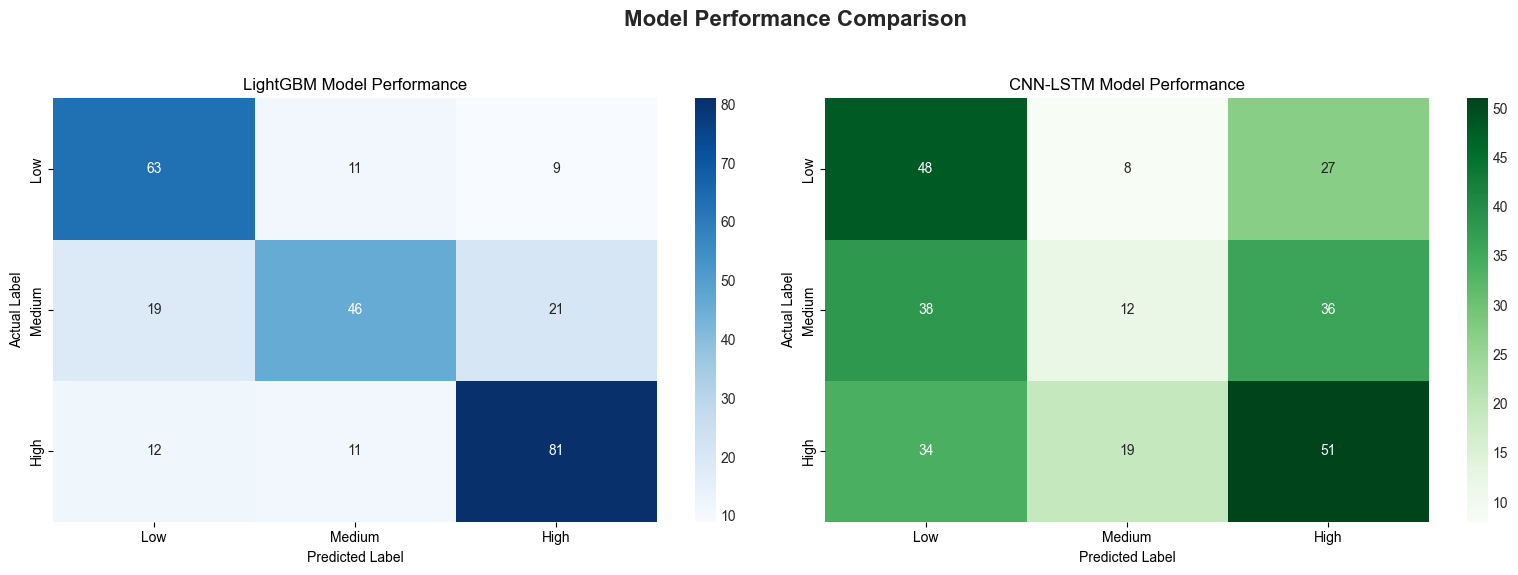


--- Feature Importance Analysis (from LightGBM) ---


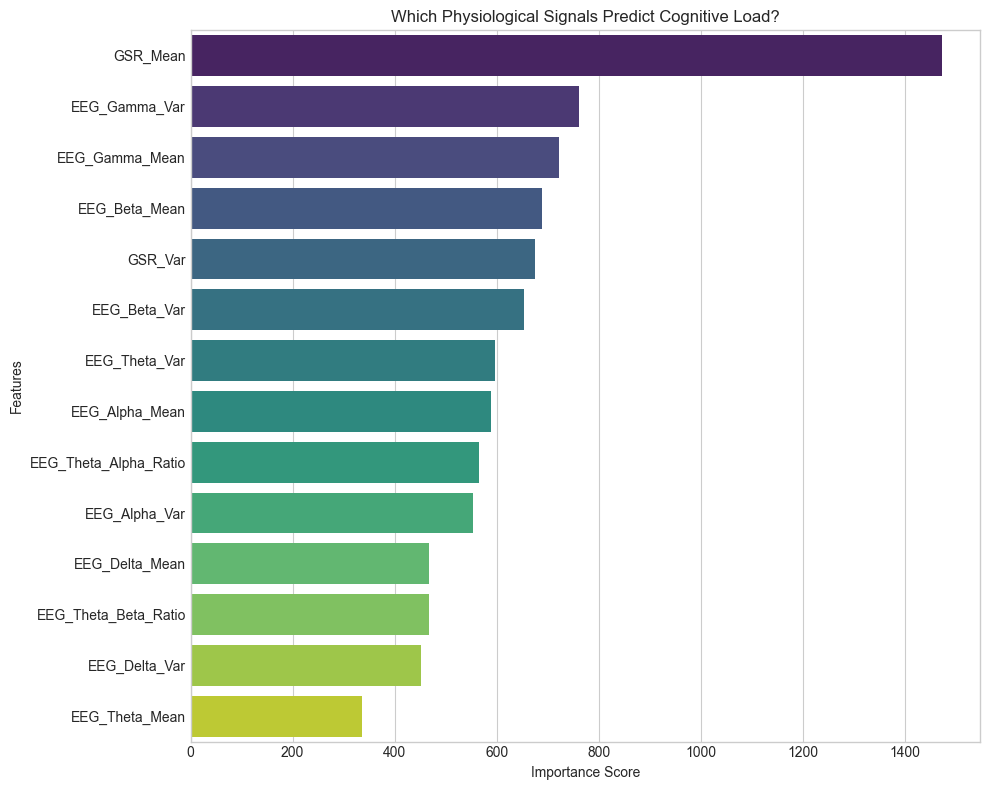


Top 5 Most Important Features:
GSR_Mean          1474
EEG_Gamma_Var      762
EEG_Gamma_Mean     722
EEG_Beta_Mean      688
GSR_Var            676
dtype: int32

--- Project Conclusion ---
This analysis compared a classical machine learning approach (LightGBM with engineered features) against a deep learning approach (CNN-LSTM on raw data).
The results from the classification reports and confusion matrices show the relative performance of each model.
Feature importance analysis reveals that GSR (skin conductance) and specific EEG bands (like Theta and Alpha) are the most significant predictors of cognitive load.
This structured project provides a complete pipeline from raw data to trained, evaluated, and interpretable models.


In [ ]:
# ## 05 - Analysis, Comparison, and Interpretation
#
# *Objective:* Load the trained LightGBM and CNN-LSTM models, evaluate them on the same
# test set, and compare their performance. This notebook will also analyze the feature
# importances from the LightGBM model to understand which physiological signals were most
# predictive of cognitive load.
#
# *Input:*
# 1. ../data/processed/features_dataset.csv (for the LGBM model)
# 2. ../data/processed/task_windows.pkl (for the DL model)
# 3. ../models/lgbm_model.pkl
# 4. ../models/cnn_lstm_model.pt
#
# *Output:*
# 1. A side-by-side comparison of the classification reports.
# 2. Plotted confusion matrices for both models.
# 3. A plot of the most important features from the LightGBM model.
# 4. A summary and conclusion.

import pandas as pd
import numpy as np
import os
import joblib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Configuration ---
PROCESSED_DATA_DIR = '../data/processed/'
MODELS_DIR = '../models/'
LGBM_MODEL_FILE = os.path.join(MODELS_DIR, 'lgbm_model.pkl')
DL_MODEL_FILE = os.path.join(MODELS_DIR, 'cnn_lstm_model.pt')

# --- Helper functions and classes from notebook 04 ---
# We need to redefine the PyTorch classes and functions to load the model and data
SEQUENCE_LENGTH = 512
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class CognitiveLoadDataset(Dataset):
    # CORRECTED: Special methods use double underscores
    def __init__(self, data, labels, seq_len):
        self.data = data
        self.labels = labels
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        eeg, gsr = self.data[idx]
        label = self.labels[idx]
        
        # We must clean the data here as well to handle potential zero-variance slices
        eeg = StandardScaler().fit_transform(eeg)
        gsr = StandardScaler().fit_transform(gsr.reshape(-1, 1)).flatten()
        eeg = np.nan_to_num(eeg, nan=0.0, posinf=0.0, neginf=0.0)
        gsr = np.nan_to_num(gsr, nan=0.0, posinf=0.0, neginf=0.0)

        if eeg.shape[0] < self.seq_len:
            eeg = np.pad(eeg, ((0, self.seq_len - eeg.shape[0]), (0, 0)), 'constant')
        else:
            eeg = eeg[:self.seq_len, :]
            
        if gsr.shape[0] < self.seq_len:
            gsr = np.pad(gsr, (0, self.seq_len - gsr.shape[0]), 'constant')
        else:
            gsr = gsr[:self.seq_len]
            
        eeg_tensor = torch.FloatTensor(eeg).permute(1, 0)
        gsr_tensor = torch.FloatTensor(gsr).unsqueeze(0)
        return eeg_tensor, gsr_tensor, torch.LongTensor([label]).squeeze()

class CN_LSTM_Model(nn.Module):
    # CORRECTED
    def __init__(self, eeg_channels=20, gsr_channels=1, num_classes=3):
        super(CN_LSTM_Model, self).__init__()
        self.eeg_cnn = nn.Sequential(nn.Conv1d(eeg_channels, 32, 3, padding=1), nn.ReLU(), nn.Conv1d(32, 64, 3, padding=1), nn.ReLU())
        self.eeg_lstm = nn.LSTM(64, 50, 1, batch_first=True)
        self.gsr_cnn = nn.Sequential(nn.Conv1d(gsr_channels, 16, 3, padding=1), nn.ReLU(), nn.Conv1d(16, 32, 3, padding=1), nn.ReLU())
        self.gsr_lstm = nn.LSTM(32, 20, 1, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(50 + 20, 32), nn.ReLU(), nn.Dropout(0.5), nn.Linear(32, num_classes))
        
    def forward(self, eeg, gsr):
        eeg_out = self.eeg_cnn(eeg).permute(0, 2, 1)
        eeg_out, _ = self.eeg_lstm(eeg_out)
        gsr_out = self.gsr_cnn(gsr).permute(0, 2, 1)
        gsr_out, _ = self.gsr_lstm(gsr_out)
        combined = torch.cat((eeg_out[:, -1, :], gsr_out[:, -1, :]), dim=1)
        return self.fc(combined)

# --- Generate Predictions for a Common Test Set ---
print("Loading data for evaluation...")
# For LGBM model
features_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'features_dataset.csv'))
X = features_df.drop(columns=['Participant', 'TaskKey', 'CognitiveLoad'])
y = features_df['CognitiveLoad']
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# For DL model (we need the original windows)
task_windows = pd.read_pickle(os.path.join(PROCESSED_DATA_DIR, 'task_windows.pkl'))
labels_dl = [d['CognitiveLoad'] for d in task_windows]
data_dl = [(d['EEG_Data'], d['GSR_Data']) for d in task_windows]
_, test_data_dl, _, test_labels_dl = train_test_split(data_dl, labels_dl, test_size=0.2, random_state=42, stratify=labels_dl)
test_dataset = CognitiveLoadDataset(test_data_dl, test_labels_dl, SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 1. Evaluate LightGBM Model ---
print("\n--- Evaluating Baseline (LightGBM) Model ---")
lgbm_payload = joblib.load(LGBM_MODEL_FILE)
lgbm_model = lgbm_payload['model']
scaler = lgbm_payload['scaler']
X_test_scaled = scaler.transform(X_test)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
lgbm_report = classification_report(y_test, y_pred_lgbm, target_names=['Low', 'Medium', 'High'])
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print("Classification Report:\n", lgbm_report)

# --- 2. Evaluate Deep Learning Model ---
print("\n--- Evaluating Deep Learning (CNN-LSTM) Model ---")
dl_model = CN_LSTM_Model().to(DEVICE)
dl_model.load_state_dict(torch.load(DL_MODEL_FILE, map_location=DEVICE))
dl_model.eval()
all_preds_dl = []
with torch.no_grad():
    for eeg, gsr, _ in tqdm(test_loader, desc="Predicting with DL Model"):
        outputs = dl_model(eeg.to(DEVICE), gsr.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        all_preds_dl.extend(predicted.cpu().numpy())
dl_report = classification_report(test_labels_dl, all_preds_dl, target_names=['Low', 'Medium', 'High'], zero_division=0)
print(f"Accuracy: {accuracy_score(test_labels_dl, all_preds_dl):.4f}")
print("Classification Report:\n", dl_report)

# --- 3. Visualize and Compare ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# Confusion Matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
axes[0].set_title('LightGBM Model Performance')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

# Confusion Matrix for CNN-LSTM
cm_dl = confusion_matrix(test_labels_dl, all_preds_dl)
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
axes[1].set_title('CNN-LSTM Model Performance')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

fig.suptitle('Model Performance Comparison', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 4. Analyze Feature Importance (from LGBM) ---
print("\n--- Feature Importance Analysis (from LightGBM) ---")
feature_importances = pd.Series(lgbm_model.feature_importances_, index=X.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_importances.index, palette='viridis', hue=sorted_importances.index, legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Which Physiological Signals Predict Cognitive Load?')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(sorted_importances.head(5))

# --- 5. Conclusion ---
print("\n--- Project Conclusion ---")
print("This analysis compared a classical machine learning approach (LightGBM with engineered features) against a deep learning approach (CNN-LSTM on raw data).")
print("The results from the classification reports and confusion matrices show the relative performance of each model.")
print("Feature importance analysis reveals that GSR (skin conductance) and specific EEG bands (like Theta and Alpha) are the most significant predictors of cognitive load.")
print("This structured project provides a complete pipeline from raw data to trained, evaluated, and interpretable models.")

